In [60]:
import simpy
import math
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
class Packet:
    def __init__(self,id,arrTime,size,bound,arrBound):
        self.size = size
        self.id = id
        self.arrTime = arrTime
        self.deptTime = 0 
        self.bound = bound
        self.arrBound = arrBound
class QueueSystem:
    def __init__(self,env,buffsize,arrRate,boundMin,boundMax,sizeMin,sizeMax,servRate,policy):
        self.arrRate = arrRate
        self.env = env
        self.boundMin = boundMin
        self.boundMax = boundMax
        self.sizeMin = sizeMin
        self.sizeMax = sizeMax
        self.buffer = []
        self.server = simpy.Resource(self.env, capacity = 1)
        # self.slotdur = slotdur
        self.slotind = 0
        self.steps = 0
        self.buffSize =  buffsize
        self.servRate = servRate
        self.departed = []
        self.rewards = []
        self.violations = 0
        self.policy = policy
        self.steps = 0
        self.numexplore = 0
        self.numexploit = 0
        self.steps= 0
        self.prev_action = torch.tensor([[0]],device=device)
        self.prev_state = self.get_current_state()
        self.prev_reward = torch.tensor([0],device=device)

    def simulateSlotted(self):
        while True:
            if self.slotind>stepsPerEpisode:
                break
            yield self.env.timeout(slotdur)
            self.slotind+=1
            # print(f'the slot index at {self.env.now} is {self.slotind}')
            for p in self.buffer:
                p.bound-=1
    def discreteArrivalProcess(self):
        id = 0
        while True:
            if self.slotind<stepsPerEpisode:
                interarrival = np.random.exponential(1.0/arrRate)
                yield self.env.timeout(interarrival)
                if(len(self.buffer)<self.buffSize):
                    packetarrTime = self.env.now
                    size = np.random.randint(self.sizeMin,self.sizeMax)
                    bound = np.random.uniform(self.boundMin,self.boundMax)
                    boundnum = math.ceil(bound/slotdur)
                    id +=1 
                    p = Packet(id,self.slotind,size,boundnum,boundnum)
                    self.buffer.append(p)
                    # print(f'packet arrived at {self.env.now}, current slot = {self.slotind}, bound = {boundnum}, size = {size}, id = {id}')
                    self.env.process(self.requestService())
            else:
                break
    def requestService(self):
        with self.server.request() as req:
            # print(f'The buffer state is: {[(p.id, p.arrTime) for p in self.buffer]} at slot = {self.slotind}')
            yield req
            # print(f'The buffer state is: {[(p.id, p.arrTime) for p in self.buffer]} at slot = {self.slotind}')
            # print(f'The buffer length is {len(self.buffer)}')
            index = self.selectPacket()
            # print(f'The selected packet is {index}')
            # print(f'The training flag is {trainFlag}')
            if trainFlag and self.steps>1:
                memory.push(self.prev_state,self.prev_action,self.get_current_state(),torch.tensor([self.prev_reward],device=device))
                # print(f'memory = {memory.memory}')
                optimize_model()
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)
            # print(f'prev_state before update = {self.prev_state}')
            # print(f'prev_action before update = {self.prev_action}')
            self.prev_state = self.get_current_state()
            self.prev_action = index
            if index is not None:
               self.prev_reward =  yield self.env.process(self.servePacket(index))
            else:
                yield self.env.timeout(0)
           
    def selectPacket(self):
        if self.policy=='fifo':
            return 0
        elif self.policy=='edfsjf':
            p = min(range(len(self.buffer)),key=lambda x:self.buffer[x].arrTime+self.buffer[x].arrBound)
            pa = self.buffer[p]
            clearslotind = math.ceil((self.env.now+pa.size/self.servRate)/slotdur)
            if pa.arrTime+pa.arrBound < clearslotind :
                return min(range(len(self.buffer)),key=lambda x:self.buffer[x].size)
            else:
                return p

        elif self.policy == 'edf':
            removepack = []
            for pa in self.buffer:
                # print(f'packet id = {pa.id} with EDD = {pa.arrTime+pa.bound} at {self.env.now}')
                # print(f'packet id = {pa.id} with TDD = {pa.arrTime+pa.bound - self.env.now-(pa.size/self.servRate)} at {self.env.now}')
                clearslotind = math.ceil((self.env.now+pa.size/self.servRate)/slotdur)
                if pa.arrTime+pa.arrBound < clearslotind :
                    removepack.append(pa)
            for pr in removepack:
                self.violations+=1
                self.buffer.remove(pr)
                    # self.buffer.remove(pa)
            if self.buffer:
                p = min(range(len(self.buffer)),key=lambda x:self.buffer[x].arrTime+self.buffer[x].arrBound)
                minInd = 0
                p0 = self.buffer[minInd]
                minTDD = p0.arrTime+p0.arrBound
                for i,p1 in enumerate(self.buffer):
                    if p1.arrTime+p1.arrBound < minTDD:
                        minTDD = p1.arrTime+p1.arrBound
                        minInd = i
                if p!=minInd:
                    print(f'calculation from min function = {p} and calculation from loop = {minInd} ')
                return minInd
            else:
                return None
        elif self.policy=='trainDeepQ' and trainFlag:
            p = self.epsilon_greedy_selection()
            return p
        elif self.policy=='testDeepQ':
            with torch.no_grad():
                state = self.get_current_state()
                network_out = policy_net(state)
                network_out[0][len(self.buffer):] = float('-inf')
                p = network_out.max(1)[1].view(1, 1)
                return p
    def get_current_state(self):
        state = np.zeros((1,1 + num_features_perPacket * self.buffSize), dtype=np.float32)
        state[0][0] = len(self.buffer)
        for i, p in enumerate(self.buffer):
            time_until_bound_normalized = (p.arrTime + p.arrBound - self.slotind)
            state[0][1 + i] = time_until_bound_normalized
            # print(f'packetSize = {p.size}')
            service_slots = math.ceil((p.size/self.servRate)/slotdur)
            # print(f'service time = {service_time_normalized}')
            # state[0][1 + i] = service_time_normalized
            state[0][1+len(self.buffer) + i] = service_slots
        
        state = torch.tensor(state,device=device)
        # print(f'current state = {state}')
        return state
    def epsilon_greedy_selection(self):
        global globalsteps
        state = self.get_current_state()
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * globalsteps / EPS_DECAY)
        # print(f'Epsilon threshold = {eps_threshold} and sample = {sample}')
        globalsteps+=1
        # print(f'Network output = {policy_net(state)}')
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                # print(f'Current state = {state}')
                network_out = policy_net(state)
                network_out[0][len(self.buffer):] = float('-inf')
                # print(f'network output = {network_out}')
                # print(f'exploitation return = {network_out.max(1)[1].view(1, 1)}')
                self.numexploit+=1
                return network_out.max(1)[1].view(1, 1)
        else:
            action = random.randint(0,len(self.buffer)-1)
            self.numexplore+=1
            # print(f'exploration return =  {torch.tensor([[action]], device=device, dtype=torch.long)}')
            return torch.tensor([[action]], device=device, dtype=torch.long)
    def servePacket(self,index):
        packet  = self.buffer[index]
        # print(f'packet {packet.id} to be cleared at {self.env.now} with current slot = {self.slotind}')
        yield self.env.timeout(packet.size/self.servRate)
        self.buffer.remove(packet)
        packet.deptTime = self.slotind
        self.departed.append(packet)
        self.steps+=1
        # reward = 0
        # if packet.deptTime - packet.arrTime > packet.bound:
        #     self.violations += 1
        #     reward-=1
        # else:
        #     reward += 1
        # for p in self.buffer:
        #     if p.bound<0:
        #         self.violations+=1
        #         reward -=1
        #         # self.buffer.remove(p)
        #     else:
        #         reward+=1
        # self.rewards.append(reward)
        # return reward
        # print(f'The packet {packet.id} is removed at {self.env.now} with slot = {self.slotind}')
        ## Working
        
        if self.slotind - packet.arrTime > packet.bound:
            self.violations+=1
            self.rewards.append(0)
            # print(f'**************Packet delay violated ****************')
            return 0
        else:
            # print(f'violation for packet id = {selected_packet.id}')
            self.rewards.append(1)
            return 1
        
        
    # def selectPacket(self):
    #     state = [p.    for p in self.buffer
    #     sample = random.random()
    #     eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps / EPS_DECAY)
    #     # print(f'Epsilon threshold = {eps_threshold} and sample = {sample}')
        
    #     # print(f'Network output = {policy_net(state)}')
    #     if sample > eps_threshold:
    #         return 
    #     else:
    #         action = random.randint(0,len(self.buffer)-1)
    #         # print(f'exploration return =  {torch.tensor([[action]], device=device, dtype=torch.long)}')
    #         return torch.tensor([[action]], device=device, dtype=torch.long)




In [61]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        #   batch.next_state)), device=device, dtype=torch.bool)
    # non_final_next_states = torch.cat([s for s in batch.next_state
                                                # if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    # print(f'state_batch = {state_batch}')
    # print(f'action_batch = {action_batch}')
    # print(f'reward_batch = {reward_batch}')
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # print(f'state action values  = {state_action_values}')
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values = target_net(state_batch).max(1)[0]
        # print(f'next_state_values = {next_state_values}')
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # print(expected_state_action_values)
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    # print(expected_state_action_values.unsqueeze(1))
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [62]:
sizeMin = 50
sizeMax = 100
servRate = 1e5
arrRate  = 2e5/(sizeMin+sizeMax)
slotdur = 1e-3
boundMin = 0.001
boundMax = 0.005
buffsize  = 10
# policy = 'trainDeepQ'
# trainDeepQ = True
# trainFlag = True
num_features_perPacket = 2
env = simpy.Environment()
print(f'duration of slot = {slotdur}')
# queueSys = QueueSystem(env,buffsize = buffsize,arrRate=arrRate,boundMin=boundMin,boundMax=boundMax,sizeMin=sizeMin,sizeMax=sizeMax,servRate = servRate,policy= policy)
# env.process(queueSys.simulateSlotted())
# env.process(queueSys.discreteArrivalProcess())
# env.run()

duration of slot = 0.001


In [63]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.005
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4
num_features_perPacket = 2
maxBufferLength = 5
n_actions = maxBufferLength
n_observations = 1+num_features_perPacket*maxBufferLength
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
stepsPerEpisode = 1000
globalsteps = 0
# print(queueSys.get_current_state())
def QueuingSimulation():
    env = simpy.Environment()
    queueSys = QueueSystem(env,buffsize = maxBufferLength,arrRate=arrRate,boundMin=boundMin,boundMax=boundMax,sizeMin=sizeMin,sizeMax=sizeMax,servRate = servRate,policy= policy)
    env.process(queueSys.simulateSlotted())
    env.process(queueSys.discreteArrivalProcess())
    env.run()
    return queueSys
num_episodes = 100
# policy = 'fifo'
policy = 'trainDeepQ'
trainFlag = True
# trainFlag = False
record_Episode_rewards= np.zeros((num_episodes,4))
from IPython.display import clear_output
maxreward = 0
for i_epi in range(num_episodes):
    np.random.seed(0)
    queSys = QueuingSimulation()
    print([len(queSys.rewards),sum(queSys.rewards)])
    # clear_output(wait=True)
    record_Episode_rewards[i_epi][0] = len(queSys.rewards)
    record_Episode_rewards[i_epi][1] = sum(queSys.rewards)
    record_Episode_rewards[i_epi][2] = queSys.numexplore
    record_Episode_rewards[i_epi][3] = queSys.numexploit
    print([i_epi,len(queSys.rewards), sum(queSys.rewards),queSys.numexplore,queSys.numexploit])
    if sum(queSys.rewards)>=maxreward:
        print(f'Changing to save model at {i_epi}')
        maxreward = sum(queSys.rewards)
        torch.save({'epoch': i_epi,'reward':maxreward,'policy_net':policy_net.state_dict(),
        'target_net':target_net.state_dict()},'policy_net')
        torch.save(target_net.state_dict(),'target_net')

[1178, 711]
[0, 1178, 711, 1104, 74]
Changing to save model at 0
[1184, 726]
[1, 1184, 726, 989, 195]
Changing to save model at 1
[1190, 755]
[2, 1190, 755, 904, 286]
Changing to save model at 2
[1176, 759]
[3, 1176, 759, 794, 382]
Changing to save model at 3
[1185, 774]
[4, 1185, 774, 683, 502]
Changing to save model at 4
[1184, 797]
[5, 1184, 797, 603, 581]
Changing to save model at 5
[1196, 810]
[6, 1196, 810, 577, 619]
Changing to save model at 6
[1190, 838]
[7, 1190, 838, 476, 714]
Changing to save model at 7
[1185, 809]
[8, 1185, 809, 462, 723]
[1204, 812]
[9, 1204, 812, 410, 794]
[1177, 806]
[10, 1177, 806, 372, 805]
[1188, 850]
[11, 1188, 850, 289, 899]
Changing to save model at 11
[1182, 827]
[12, 1182, 827, 277, 905]
[1183, 849]
[13, 1183, 849, 229, 954]
[1185, 844]
[14, 1185, 844, 219, 966]
[1183, 833]
[15, 1183, 833, 195, 988]
[1193, 837]
[16, 1193, 837, 161, 1032]
[1187, 857]
[17, 1187, 857, 147, 1040]
Changing to save model at 17
[1185, 853]
[18, 1185, 853, 142, 1043]
[11

Text(0, 0.5, 'Reward or Successful Delivery')

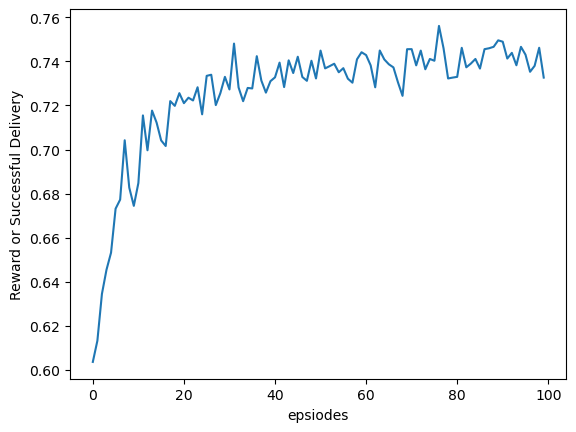

In [64]:
plt.plot(record_Episode_rewards[:,1]/record_Episode_rewards[:,0])
plt.xlabel('epsiodes')
plt.ylabel('Reward or Successful Delivery')

In [65]:
import pickle
fname = 'Fixedwithoutcounter'+'.pkl'
with open(fname,'wb') as f:
    pickle.dump(record_Episode_rewards,f)